In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
import logging

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FastTensorDataloader

In [2]:
from torch.utils.data import Dataset,Subset,TensorDataset

class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors.
    
    It is much faster than TensorDataset + DataLoader because dataloader grabs individual indices of the dataset and calls cat (slow).

    Notes
    =====

    Adapted from https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6. 

    """
    def __init__(self, tensors, batch_size=0, shuffle=False):
        """Initialize a FastTensorDataLoader.

        Parameters
        ----------
        tensors : list of tensors or torch.Dataset or torch.Subset or list of torch.Subset object containing a tensors object
            tensors to store. Must have the same length @ dim 0.
        batch_size : int, optional
            batch size, by default 0 (==single batch)
        shuffle : bool, optional
            if True, shuffle the data *in-place* whenever an
            iterator is created out of this object, by default False

        Returns
        -------
        FastTensorDataLoader
            dataloader-like object

        """

        # check input type
        if isinstance(tensors,Subset):
            tensors = [ tensors.dataset.tensors[i][tensors.indices] for i in range(len(tensors.dataset.tensors)) ]
        elif isinstance(tensors,Dataset):
            tensors = [ tensors.tensors[i] for i in range(len(tensors.tensors)) ]
        # check for input type list of Subset, and create a list of tensors
        elif (isinstance(tensors,list) and isinstance(tensors[0],Subset) ):
            new_tensors = []
            tensor = torch.Tensor()
            for j in range( len( tensors[0].dataset.tensors ) ):
                for i in range( len( tensors ) ):
                    if i == 0:
                        tensor = tensors[i].dataset.tensors[j][tensors[i].indices]
                    else:    
                        tensor = torch.cat( (tensor, tensors[i].dataset.tensors[j][tensors[i].indices]), 0 )
                new_tensors.append(tensor)
            tensors = new_tensors

        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size if batch_size > 0 else self.dataset_len
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(self.dataset_len)
        else:
            self.indices = None
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        if self.indices is not None:
            indices = self.indices[self.i:self.i+self.batch_size]
            batch = tuple(torch.index_select(t, 0, indices) for t in self.tensors)
        else:
            batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

def test_fasttensordataloader(): 
    X = torch.arange(1,11).unsqueeze(1)
    y = X**2
    dataloader = FastTensorDataLoader([X,y],batch_size=2)
    print(next(iter(dataloader)))

if __name__ == "__main__":
    test_fasttensordataloader()
    



(tensor([[1],
        [2]]), tensor([[1],
        [4]]))


Util for computing running ave/std

In [3]:
class RunningAverageStd(object):
    """
    Implements Welford's algorithm for computing a running mean
    and standard deviation as described at: 
        http://www.johndcook.com/standard_deviation.html

    Adapted for pytorch from: https://gist.github.com/alexalemi/2151722

    can take single values or iterables

    Attributes
    ----------
    mean : 
        returns the mean
    std : int
        returns the std
    range: 
        alias for std
    meanfull: 
        returns the mean and std of the mean
    """

    def __init__(self,lst=None):
        self.k = 0
        self.M = None
        self.S = None
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        if self.M is not None:
            newM = self.M + (x - self.M)*1./self.k
            newS = self.S + (x - self.M)*(x - newM)
        else: 
            newM = x
            newS = x * 0.
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def reset(self):
        self.k = 0
        self.M = None
        self.S = None

    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/torch.sqrt(self.k)
    @property
    def std(self):
        if self.k==0:
            return self.S
        if self.k==1:
            return 0
        return torch.sqrt(self.S/(self.k-1))
    @property
    def range(self):
        return self.std
    def __repr__(self):
        return f"<Running average +- std: {self.mean} +- {self.std}>"

def test_running_average():

    foo = RunningAverageStd()
    foo(torch.arange(0, 50 ))
    print(foo)
    foo(torch.arange(51,100))
    print(foo)
    assert foo.mean.ndim == 0

    foo = RunningAverageStd()
    foo(torch.arange(0, 50).reshape(10,5))
    print(foo)
    assert (foo.mean.ndim == 1 ) and ( foo.std.shape[0] == 5)
    foo.reset()

if __name__ == "__main__":
    test_running_average()

<Running average +- std: 24.5 +- 14.57737922668457>
<Running average +- std: 49.49495315551758 +- 29.15909194946289>
<Running average +- std: tensor([22.5000, 23.5000, 24.5000, 25.5000, 26.5000]) +- tensor([15.1383, 15.1383, 15.1383, 15.1383, 15.1383])>


In [4]:
class RunningMinMax(object):
    """
    Running calculation of min and max.

    can take single values or iterables

    Attributes
    ----------
    min : 
        returns the min
    max : int
        returns the max
    mean: 
        returns the mean (min+max)/2
    range: 
        returns the range (max-min)
    """

    def __init__(self,lst=None):
        self.k = 0 
        self.Min = None
        self.Max = None
        self.M = None
        self.S = None
        
        self.dim = 0
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        if self.M is not None:
            min_stack = torch.stack((torch.min(x,self.dim)[0], self.Min )) 
            newMin = torch.min(min_stack,dim=self.dim)[0]
            max_stack = torch.stack((torch.max(x,self.dim)[0], self.Max )) 
            newMax = torch.max(max_stack,dim=self.dim)[0]
        else: 
            newMin = torch.min(x,dim=self.dim).values
            newMax = torch.max(x,dim=self.dim).values

        self.Min, self.Max = newMin, newMax
        self.M = (self.Max + self.Min) / 2.0
        self.S = (self.Max - self.Min) / 2.0
    
    def reset(self):
        self.k = 0
        self.Min = None
        self.Max = None
        self.M = None
        self.S = None

    def __call__(self,x):
        if (x is not None) and (x.ndim == 0):
            x = x.unsqueeze(0) 
        self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def range(self):
        return self.S
    def __repr__(self):
        return f"<Running mean and range : {self.mean}, {self.range} (min and max: [{self.Min},{self.Max}])>"

def test_running_min_max():

    print('-------------')
    foo = RunningMinMax()
    foo(torch.arange(0, 50 ))
    print(foo)
    foo(torch.arange(51,100))
    print(foo)
    assert foo.mean.ndim == 0
    print('-------------')
    foo = RunningMinMax()
    foo(torch.arange(0, 50).reshape(10,5))
    print(foo)
    assert (foo.mean.ndim == 1 ) and ( foo.range.shape[0] == 5)
    foo.reset()
    print('-------------')
    foo = RunningMinMax()
    X = torch.Tensor([[1,100,],[10,2],[5,50]])
    foo(X)
    print(foo)

if __name__ == "__main__":
    test_running_min_max()

-------------
<Running mean and range : 24.5, 24.5 (min and max: [0,49])>
<Running mean and range : 49.5, 49.5 (min and max: [0,99])>
-------------
<Running mean and range : tensor([22.5000, 23.5000, 24.5000, 25.5000, 26.5000]), tensor([22.5000, 22.5000, 22.5000, 22.5000, 22.5000]) (min and max: [tensor([0, 1, 2, 3, 4]),tensor([45, 46, 47, 48, 49])])>
-------------
<Running mean and range : tensor([ 5.5000, 51.0000]), tensor([ 4.5000, 49.0000]) (min and max: [tensor([1., 2.]),tensor([ 10., 100.])])>


Modules class

In [5]:
class FeedForward(pl.LightningModule):

    def __init__(
        self, layers, activation="relu", **kwargs 
    ):
        """
        Define a simple neural network given the list of layers.

        Parameters
        ----------
        layers : list
            Number of neurons per layer
        activation : string
            Activation function (relu, tanh, elu, linear)
        **kwargs:
            Optional arguments passed to torch base class
        """
        super().__init__(**kwargs)

        # get activation function
        activ = None
        if activation == "relu":
            activ = torch.nn.ReLU(True)
        elif activation == "elu":
            activ = torch.nn.ELU(True)
        elif activation == "tanh":
            activ = torch.nn.Tanh()
        elif activation == "linear":
            print("WARNING: no activation selected")
        else:
            raise ValueError(
                "Unknown activation. options: 'relu','elu','tanh','linear'. "
            )

        # Create architecture
        if not isinstance(layers[0],int):
            raise TypeError('layers should be a list-type of integers.')
        
        modules = []
        for i in range(len(layers) - 1):
            if i < len(layers) - 2:
                modules.append(torch.nn.Linear(layers[i], layers[i + 1]))
                if activ is not None:
                    modules.append(activ)
            else:
                modules.append(torch.nn.Linear(layers[i], layers[i + 1]))

        # store model and attributes
        self.nn     = torch.nn.Sequential(*modules)
        self.n_in   = layers[0]
        self.n_out  = layers[-1]

    def forward(self, x: torch.tensor) -> (torch.tensor):
        return self.nn(x)

def test_feedforward():
    torch.manual_seed(42)
    
    n_in = 2
    layers = [2,10,1]
    model = FeedForward(layers,activation='relu')
    
    print(model)

    X = torch.zeros(n_in)
    print(model(X))

if __name__ == "__main__":
    test_feedforward()

FeedForward(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
tensor([0.1120], grad_fn=<AddBackward0>)


Decorator tests

In [6]:
import inspect
import functools

def apply_hooks(f):
    @functools.wraps(f)
    def wrapper(self,*args, **kwargs):
        # loop over all saved hooks in class
        for hook,funcs in self.hooks.items():
            # check if the current function name matches a saved hook
            # in case execute all the associated funcs
            if hook == f.__name__:
                # if it is a string convert to iterable
                if isinstance(funcs, str):
                    funcs = [ funcs ] 
                for func in funcs:
                    getattr(self,func)()
        return f(self,*args, **kwargs)

    return wrapper

allowed_hooks = ["on_predict_batch_end","on_predict_batch_start","on_predict_end","on_predict_epoch_end","on_predict_epoch_start","on_predict_start","on_test_batch_end","on_test_batch_start","on_test_end","on_test_epoch_end","on_test_epoch_start","on_test_start","on_train_batch_end","on_train_batch_start","on_train_end","on_train_epoch_end","on_train_epoch_start","on_train_start","on_validation_batch_end","on_validation_batch_start","on_validation_end","on_validation_epoch_end","on_validation_epoch_start","on_validation_start"]

"""Iterate through a list of methods in a class and apply decorator."""
def decorate_methods(decorator, methods=allowed_hooks):
    def decorate(cls):
        for name, fn in inspect.getmembers(cls, inspect.isroutine):
            if name in methods :
                setattr(cls, name, decorator(fn))
        return cls

    return decorate

@decorate_methods(apply_hooks,methods=allowed_hooks)
class Normalization(pl.LightningModule):
    """_summary_
    """

    def __init__(self, n_in, mode = 'std', hooks = {'on_train_epoch_end': 'save_stats', 'on_train_epoch_start': 'reset_stats' }):
        
        super().__init__()
        
        # buffers containing mean and range for standardization
        self.register_buffer("Mean", torch.zeros(n_in))
        self.register_buffer("Range", torch.ones(n_in))

        self.n_in = n_in
        self.n_out = n_in

        if mode == 'std':
            self.running_stats = RunningAverageStd()
        elif mode == 'minmax':
            self.running_stats = RunningMinMax()
        else:
            raise ValueError(f'The normalization mode should be one of the following: "std", "minmax", not {mode}.')

        self.hooks = hooks

    def reset_stats(self) -> None:
        """Reset running statistics."""
        self.running_stats.reset()

    @torch.no_grad()
    def save_stats(self) -> None:
        """Save running statistics into class methods for later inference."""
        self.Mean = self.running_stats.mean.detach()
        self.Range = self.running_stats.range.detach()

    def get_mean_range(self, size : torch.Size) -> tuple[torch.Tensor]:
        """Return mean and range reshaped according to tensor size. 

        Parameters
        ----------
        size : torch.Size
        
        Returns
        -------
        (Mean, Range): Tuple[torch.Tensor]
            Mean and range 

        """
        if len(size) == 2:
            batch_size = size[0]
            x_size = size[1]
            Mean = self.Mean.unsqueeze(0).expand(batch_size, x_size)
            Range = self.Range.unsqueeze(0).expand(batch_size, x_size)
        elif len(size) == 1:
            Mean = self.Mean
            Range = self.Range
        else:
            raise ValueError(
                f"Input tensor must of shape (n_features) or (n_batch,n_features), not {size}."
            )
        return (Mean,Range)

    def forward(self, x: torch.Tensor) -> (torch.Tensor):
        """
        Compute standardized inputs.

        Parameters
        ----------
        x: torch.Tensor
            input/output

        Returns
        -------
        out : torch.Tensor
            standardized inputs
        """
        # accumulate statistics during training
        if self.training:
            self.running_stats(x)
        # get mean and range
        Mean,Range = self.get_mean_range(x.size())
    
        return x.sub(Mean).div(Range)

    def inverse(self, x: torch.Tensor) -> (torch.Tensor):
        """
        Remove standardization.

        Parameters
        ----------
        x: torch.Tensor
            input

        Returns
        -------
        out : torch.Tensor
            un-normalized inputs
        """
        # get mean and range
        Mean,Range = self.get_mean_range(x.size())

        return x.mul(Range).add(Mean)

def test_normalization():
    torch.manual_seed(42)

    n_in = 2
    norm = Normalization(n_in, mode='std')

    X = torch.randn((5,n_in))*10

    # accumulate stats during training
    print('TRAIN')
    norm.train()
    # reset variables 
    norm.on_train_epoch_start()
    #norm.reset_stats()
    # propagate X and accumulate
    print(norm(X))
    # display current stats
    print('running stats')
    print(norm.running_stats)
    # save running stats for inference
    norm.on_train_epoch_end()
    #norm.save_stats()
    print('saved stats')
    print(norm.Mean,norm.Range)

    # Then use the estimate for predict
    print('EVAL')
    norm.eval()
    print('Normalize')
    print(norm(X))
    print('Un-normalize')
    print(norm.inverse(norm(X)))
    print('-------------')
    # check other way of normalizing
    norm = Normalization(n_in, mode='minmax')
    norm.train()
    X = torch.Tensor([[1,100,],[10,2],[5,50]])
    print('input')
    print(X)
    norm(X)
    norm.save_stats()
    print('min', norm.running_stats.Min)
    print('max', norm.running_stats.Max)
    assert torch.allclose( norm.running_stats.Min, X.min(0)[0])
    assert torch.allclose( norm.running_stats.Max, X.max(0)[0])

if __name__ == "__main__":
    test_normalization()

TRAIN
tensor([[  3.3669,   1.2881],
        [  2.3446,   2.3033],
        [-11.2286,  -1.8633],
        [ 22.0820,  -6.3800],
        [  4.6166,   2.6735]])
running stats
<Running average +- std: tensor([ 4.2363, -0.3957]) +- tensor([11.8544,  3.7916])>
saved stats
tensor([ 4.2363, -0.3957]) tensor([11.8544,  3.7916])
EVAL
Normalize
tensor([[-0.0733,  0.4441],
        [-0.1596,  0.7118],
        [-1.3046, -0.3871],
        [ 1.5054, -1.5783],
        [ 0.0321,  0.8095]])
Un-normalize
tensor([[  3.3669,   1.2881],
        [  2.3446,   2.3033],
        [-11.2286,  -1.8633],
        [ 22.0820,  -6.3800],
        [  4.6166,   2.6735]])
-------------
input
tensor([[  1., 100.],
        [ 10.,   2.],
        [  5.,  50.]])
min tensor([1., 2.])
max tensor([ 10., 100.])


CV example class

In [9]:
import functools
import inspect
from typing import Any

def call_submodules_hooks(f):
    @functools.wraps(f)
    def wrapper(self,*args, **kwargs):
        for child in self.children():
            if isinstance(child,pl.LightningModule):
                func = getattr(child,f.__name__)
                func(*args, **kwargs)
        return f(self,*args, **kwargs)

    return wrapper

allowed_hooks = ["on_after_backward","on_after_batch_transfer","on_before_backward","on_before_batch_transfer","on_before_optimizer_step","on_before_zero_grad","on_fit_end","on_fit_start","on_load_checkpoint","on_predict_batch_end","on_predict_batch_start","on_predict_end","on_predict_epoch_end","on_predict_epoch_start","on_predict_model_eval","on_predict_start","on_save_checkpoint","on_test_batch_end","on_test_batch_start","on_test_end","on_test_epoch_end","on_test_epoch_start","on_test_model_eval","on_test_model_train","on_test_start","on_train_batch_end","on_train_batch_start","on_train_end","on_train_epoch_end","on_train_epoch_start","on_train_start","on_validation_batch_end","on_validation_batch_start","on_validation_end","on_validation_epoch_end","on_validation_epoch_start","on_validation_model_eval","on_validation_model_train","on_validation_start"]
allowed_hooks = ["on_predict_batch_end","on_predict_batch_start","on_predict_end","on_predict_epoch_end","on_predict_epoch_start","on_predict_start","on_test_batch_end","on_test_batch_start","on_test_end","on_test_epoch_end","on_test_epoch_start","on_test_start","on_train_batch_end","on_train_batch_start","on_train_end","on_train_epoch_end","on_train_epoch_start","on_train_start","on_validation_batch_end","on_validation_batch_start","on_validation_end","on_validation_epoch_end","on_validation_epoch_start","on_validation_start"]

"""Iterate through a list of methods in a class and apply decorator."""
def decorate_methods(decorator, methods=allowed_hooks):
    def decorate(cls):
        for name, fn in inspect.getmembers(cls, inspect.isroutine):
            if name in methods :
                setattr(cls, name, decorator(fn))
        return cls

    return decorate

In [33]:
@decorate_methods(call_submodules_hooks,methods=allowed_hooks)
class SimpleCV(pl.LightningModule):
    """Example of collective variable obtained with a regression task.
    Initalize the architecture as a torch.nn.sequential model and the 
    loss function (MSE) in the training_step function. """
    
    def __init__(self, options : dict[str, Any] = None , modules : list = None, **kwargs):
        """Initialize the CV either from a dictionary or with a list of pl.LightningModules for greater flexibility. 

        If instead a list of modules is given they will supersede the options dict.

        Parameters
        ----------
        options : dict[str, Any], optional
            The allowed keys are :
            - layers  :  list of nodes per layers (e.g. [n_input, n_hidden, n_output]).
            - activation : type of activation function (see FeedForward class) 
            - normIn  : how to normalize inputs (std,minmax,False/None), default std
        modules : list of pl.LightningModules, alternative
            list of modules, by default None
        """
        super().__init__(**kwargs)

        if ( modules is not None ):
            self.blocks = torch.nn.Sequential(*modules)
        else:
            # parse layers
            try:
                layers = options['layers']
            except KeyError:
                raise KeyError('the key layers (e.g. [n_input, n_hidden, n_output]) is missing in the options dict')
            n_in = layers[0] 
            # parse activation
            activation = options['activation'] if 'activation' in options else 'relu'
            # create NN
            nn = FeedForward(layers, activation=activation)
            # norm inputs
            modules = []
            if ( 'normIn' in options ):
                normIn = options['normIn']
                if (normIn != False) and (normIn is not None):
                    if normIn == True:
                        normIn = 'std'
                    mode = normIn
                    modules.append(Normalization(n_in,mode=normIn))
            modules.append(nn)
                       
            self.blocks = torch.nn.Sequential(*modules)

        self.example_input_array = torch.ones(modules[0].n_in)

        # parameters
        self.n_in = modules[0].n_in
        self.n_out = modules[-1].n_out
        self.lr = 1e-3

    def forward(self, x: torch.tensor) -> (torch.tensor):
        y = self.blocks(x)
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def loss_function(self, input, target):
        # MSE LOSS
        loss = (input-target).square().mean()
        return loss

    def training_step(self, train_batch, batch_idx):
        x, labels = train_batch
        y = self(x)
        loss = self.loss_function(y,labels)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, labels = val_batch
        y = self(x)
        loss = self.loss_function(y,labels)
        self.log('val_loss', loss, on_epoch=True)

def test_simplecv():
    n_in, n_out = 2,1 
    layers = [n_in, 5, 10, n_out]

    # initialize via dictionary
    options= { 'layers' : layers ,
               'activation' : 'relu',
               'normIn' : True }    
    model = SimpleCV( options )
    print(model)
    print('----------')

    # initialize via list of modules
    modules = [ Normalization(n_in),
                FeedForward(layers, activation='tanh') ]
    model = SimpleCV( modules=modules )
    print(model)

    # create dataset
    X = torch.randn((100,2))
    y = X.square().sum(1)
    dataset = TensorDataset(X,y)
    datamodule = TensorDataModule(dataset,lengths=[0.75,0.2,0.05], batch_size=25)
    # train model
    trainer = pl.Trainer(accelerator='cpu',max_epochs=2,logger=None)
    trainer.fit( model, datamodule )

if __name__ == "__main__":
    test_simplecv() 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | blocks | Sequential | 86     | [2]      | [1]      
-------------------------------------------------------------
86        Trainable params
0         Non-trainable params
86        Total params
0.000     Total estimated model params size (MB)


SimpleCV(
  (blocks): Sequential(
    (0): Normalization()
    (1): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=2, out_features=5, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=5, out_features=10, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)
----------
SimpleCV(
  (blocks): Sequential(
    (0): Normalization()
    (1): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=2, out_features=5, bias=True)
        (1): Tanh()
        (2): Linear(in_features=5, out_features=10, bias=True)
        (3): Tanh()
        (4): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)
Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 288.13it/s, loss=8.75]          

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 249.26it/s, loss=8.75]


Create dataset

In [38]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from typing import Union

class TensorDataModule(pl.LightningDataModule):
    """Lightning DataModule constructed for TensorDataset(s)."""
    def __init__(self, dataset: TensorDataset, lengths=[0.8,0.2,0], batch_size: Union[int,list] = 32, shuffle : Union[bool,list] =  False,  generator : torch.Generator = None):
        """Create a DataModule derived from TensorDataset, which returns train/valid/test dataloaders.

        For the batch_size and shuffle parameters either a single value or a list-type of values (with same size as lenghts) can be provided.

        Parameters
        ----------
        dataset : TensorDataset
            Train dataset
        lengths : list, optional
            Lenghts of the training/validation/test datasets , by default [0.8,0.2]
        batch_size : int or list, optional
            Batch size, by default 32
        shuffle : Union[bool,list], optional
            whether to shuffle the batches from the dataloader, by default False
        generator : torch.Generator, optional
            set random generator for reproducibility, by default None
        """
        super().__init__()
        self.dataset = dataset
        self.lengths = lengths
        if isinstance(batch_size,int):
            self.batch_size = [batch_size for _ in lengths ]
        else:
            self.batch_size = batch_size
        if isinstance(shuffle,bool):
            self.shuffle = [shuffle for _ in lengths ]
        else:
            self.shuffle = shuffle
        self.generator = None

    def setup(self, stage: str):
        self.dataset_splits = random_split(self.dataset, self.lengths, generator=self.generator)

    def train_dataloader(self):
        """Return training dataloader."""
        return FastTensorDataLoader(self.dataset_splits[0], batch_size=self.batch_size[0],shuffle=self.shuffle[0])

    def val_dataloader(self):
        """Return validation dataloader."""
        return FastTensorDataLoader(self.dataset_splits[1], batch_size=self.batch_size[1],shuffle=self.shuffle[1])

    def test_dataloader(self):
        """Return test dataloader."""
        if len(self.lengths) >= 3:
            return DataLoader(self.dataset_splits[2], batch_size=self.batch_size[2],shuffle=self.shuffle[2])
        else: 
            raise ValueError('Test dataset not available, you need to pass three lenghts to datamodule.')  

    def predict_dataloader(self):
        raise NotImplementedError

    def teardown(self, stage: str):
        pass 

def test_tensordatamodule():
    torch.manual_seed(42)
    X = torch.randn((100,2))
    y = X.square()
    dataset = TensorDataset(X,y)

    datamodule = TensorDataModule(dataset,lengths=[0.75,0.2,0.05],batch_size=25)
    datamodule.setup('fit')
    loader = datamodule.train_dataloader()
    for data in loader:
        x_i, y_i = data
        print(x_i.shape, y_i.shape)
    datamodule.val_dataloader()
    datamodule.test_dataloader()

if __name__ == "__main__":
    test_tensordatamodule() 

torch.Size([25, 2]) torch.Size([25, 2])
torch.Size([25, 2]) torch.Size([25, 2])
torch.Size([25, 2]) torch.Size([25, 2])


In [36]:
from torch.utils.data import TensorDataset, DataLoader, random_split

torch.manual_seed(42)

n_points = 1000

n_in = 1
n_out = 1

X = torch.randn((n_points,n_in))*2
y = X.square()

dataset = TensorDataset(X,y)

datamodule = TensorDataModule(dataset) 

Create model and forward

In [37]:
from pytorch_lightning.utilities.model_summary import ModelSummary

layers = [n_in, 10, 20, 10, n_out]

modules = [ Normalization(n_in),
            FeedForward(layers,activation='relu') ]

model = SimpleCV( modules = modules )

print(model)
summary = ModelSummary(model, max_depth=-1)
print(summary)

SimpleCV(
  (blocks): Sequential(
    (0): Normalization()
    (1): FeedForward(
      (nn): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=10, out_features=20, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=20, out_features=10, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)
  | Name          | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------------
0 | blocks        | Sequential    | 461    | [1]      | [1]      
1 | blocks.0      | Normalization | 0      | [1]      | [1]      
2 | blocks.1      | FeedForward   | 461    | [1]      | [1]      
3 | blocks.1.nn   | Sequential    | 461    | [1]      | [1]      
4 | blocks.1.nn.0 | Linear        | 20     | [1]      | [10]     
5 | blocks.1.nn.1 | ReLU          | 0      | [10]     | [

In [29]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger,TensorBoardLogger

trainer = pl.Trainer(accelerator='gpu', devices=1, 
                        callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta=0.1, patience=10, verbose=False)],
                        max_epochs=50, log_every_n_steps=1,logger=[TensorBoardLogger("logs2/"), CSVLogger("logs", name="enrico") ])

trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | blocks | Sequential | 461    | [1]      | [1]      
-------------------------------------------------------------
461       Trainable params
0         Non-trainable params
461       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 32/32 [00:00<00:00, 138.45it/s, loss=0.397, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:00<00:00, 135.12it/s, loss=0.397, v_num=2]


In [19]:
model.blocks[0].Range

tensor([1.])

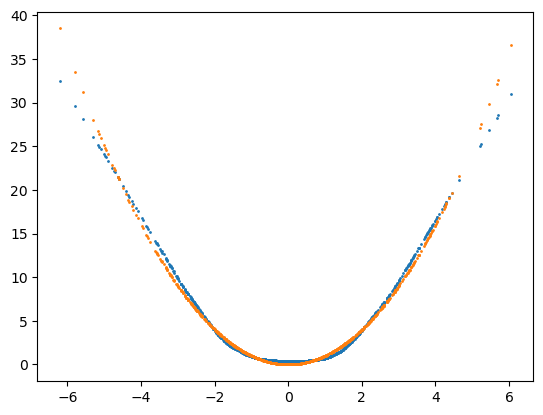

In [100]:
import matplotlib.pyplot as plt
model.eval()
plt.scatter(X, model(X).detach().numpy(),s=1)
plt.scatter(X, y, s=1)
plt.show()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Autoencoder 

In [59]:
from typing import Any,Union

@decorate_methods(call_submodules_hooks, methods=allowed_hooks)
class AutoEncoderCV(pl.LightningModule):
    """AutoEncoding Collective Variable."""
    
    def __init__(self, encoder_layers : list , decoder_layers : list = None, options : dict[str,Any] = {} ):
        """TODO 

        """
        super().__init__()

        # Members
        blocks = ['normIn','encoder','normOut','decoder'] 

        # Initialize defaults
        for b in blocks:
            self.__setattr__(b,None)
            options.setdefault(b,{})

        # parse info from args
        if decoder_layers is None:
            decoder_layers = encoder_layers[::-1]
        self.n_in = layers[0]
        self.n_out = layers[-1]

        # initialize normIn
        o = 'normIn'
        if ( not options[o] ) and (options[o] is not None):
            self.normIn = Normalization(self.n_in,**options[o]) 

        # initialize encoder
        o = 'encoder'
        self.encoder = FeedForward(encoder_layers, **options[o])

         # initialize normOut
        o = 'normOut'
        if ( not options[o] ) and (options[o] is not None):
            self.normOut = Normalization(self.n_out,**options[o]) 

        # initialize encoder
        o = 'decoder'
        self.decoder = FeedForward(decoder_layers, **options[o])

        # set input example
        self.example_input_array = torch.ones(self.n_in)

    def forward(self, x: torch.tensor) -> (torch.tensor):
        if self.normIn is not None:
            x = self.normIn(x)
        x = self.encoder(x)
        if self.normOut is not None:
            x = self.normOut(x)
        
        return x

    def encode_decode(self, x: torch.tensor) -> (torch.tensor):
        x = self.forward(x)
        x = self.decoder(x)
        if self.normIn is not None:
            x = self.normIn.inverse(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss_function(self, input, target):
        # Reconstruction (MSE) loss
        loss = (input-target).square().mean()
        return loss

    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        x_hat = self.encode_decode(x)
        loss = self.loss_function(x_hat,x)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        x_hat = self.encode_decode(x)
        loss = self.loss_function(x_hat,x)
        self.log('val_loss', loss, on_epoch=True)

def test_autoencodercv():
    n_in, n_out = 8,2
    layers = [n_in, 6, 4, n_out]

    # initialize via dictionary
    opts = { 'normIn'  : None,
             'encoder' : { 'activation' : 'relu' },
             'normOut' : { 'mode'   : 'std' },
           } 
    model = AutoEncoderCV( encoder_layers=layers, options=opts )
    print(model)
    print('----------')


if __name__ == "__main__":
    test_autoencodercv() 

AutoEncoderCV(
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=8, out_features=6, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=6, out_features=4, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=4, out_features=2, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=4, out_features=6, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=6, out_features=8, bias=True)
    )
  )
)
----------


In [46]:
n_in, n_out = 2,1

blocks = ['normIn','encoder','normOut','decoder'] 

for b in blocks:
    options.setdefault(b,{})

layers = [n_in, 10, 20, 10, n_out]

options = { 'normIn'  : None,
            'encoder' : { 'activation' : 'relu' },
            'normOut' : { 'mode'   : 'std' },
            'decoder' : {  }
          }

In [50]:
n_in, n_out = 2,1
layers = [n_in, 10, 20, 10, n_out]

options = { 'normIn'  : None,
            'encoder' : { 'activation' : 'relu' },
            'normOut' : { 'mode'   : 'std' },
          }

blocks = ['normIn','encoder','normOut','decoder'] 

for b in blocks:
    options.setdefault(b,{})

options

{'normIn': None,
 'encoder': {'activation': 'relu'},
 'normOut': {'mode': 'std'},
 'decoder': {}}

In [113]:
n_in, n_out = 2,1
layers = [n_in, 10, 20, 10, n_out]

options= { 'encoder' : layers ,
            'activation' : 'relu',
            'normIn' : True, 
            'normOut' : 'minmax' }    
model = AutoEncoderCV( options )

In [114]:
torch.manual_seed(42)
X = torch.randn((1000,n_in))*100

dataset = TensorDataset(X)

datamodule = TensorDataModule(dataset,batch_size=32)

trainer = pl.Trainer(accelerator='gpu', devices=1, 
                        callbacks=[EarlyStopping(monitor="val_loss")],
                        max_epochs=100, log_every_n_steps=1)

trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | normIn  | Normalization | 0      | [2]      | [2]      
1 | encoder | FeedForward   | 471    | [2]      | [1]      
2 | normOut | Normalization | 0      | [1]      | [1]      
3 | decoder | FeedForward   | 472    | ?        | ?        
-----------------------------------------------------------------
943       Trainable params
0         Non-trainable params
943       Total params
0.004     Total estimated model pa

Epoch 48: 100%|██████████| 32/32 [00:00<00:00, 205.75it/s, loss=4.77e+03, v_num=4]


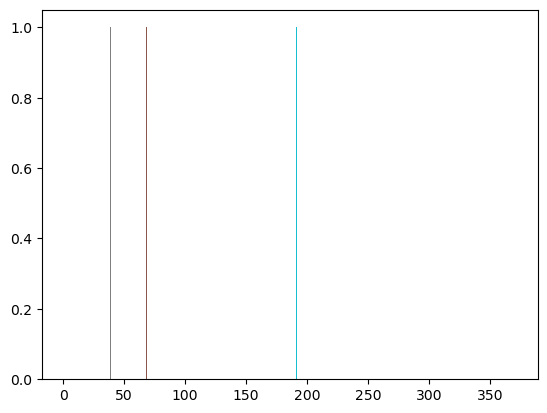

In [124]:
model.eval() 
X_hat = model.encode_decode(X).detach().numpy()
s = model(X).detach().numpy()
plt.figure()
plt.scatter(X[:,1],X_hat[:,1])
plt.figure()
#plt.hist((X-X_hat).square().sum(1).sqrt().div(X.square().sum(1).sqrt()).numpy(),bins=100)#,(X-X_hat)[:,1])
plt.show()

In [ ]:
model.eval()
model.to_torchscript(method="trace")

In [120]:
model(X[0])

tensor([0.4775], grad_fn=<DivBackward0>)